# All Fruits-360 Pipeline
This notebook starts from the fine-grained dataloader (1.1) and adds EDA, color-hist features, PCA exploration, and classic ML models.

In [1]:
import os
import gc
import subprocess
import shutil
import random
import time
import threading
import tracemalloc
import json
import hashlib
from datetime import datetime
from pathlib import Path
import numpy as np
import torch
import psutil
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Import dataset

In [2]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR)
assert os.path.exists(TEST_DIR)

print(f"Train dir: {TRAIN_DIR}")
print(f"Test dir: {TEST_DIR}")

Train dir: dataset/fruit360/Training
Test dir: dataset/fruit360/Test


## Memory profiling utilities

In [3]:
def measure_peak_ram(func, *args, poll_interval=0.05, **kwargs):
    gc.collect()
    if tracemalloc.is_tracing():
        tracemalloc.stop()
    tracemalloc.start()
    process = psutil.Process(os.getpid())
    peak_rss = process.memory_info().rss
    stop_event = threading.Event()

    def poll():
        nonlocal peak_rss
        while not stop_event.is_set():
            rss = process.memory_info().rss
            if rss > peak_rss:
                peak_rss = rss
            time.sleep(poll_interval)

    t = threading.Thread(target=poll, daemon=True)
    t.start()
    try:
        result = func(*args, **kwargs)
    finally:
        stop_event.set()
        t.join()
        _, peak_py = tracemalloc.get_traced_memory()
        tracemalloc.stop()
    return result, peak_rss, peak_py

def fit_with_peak(model, X, y, label, mem_results):
    _, peak_rss, peak_py = measure_peak_ram(model.fit, X, y)
    mem_results.append({
        "model": label,
        "peak_rss_mb": peak_rss / (1024 ** 2),
        "peak_py_mb": peak_py / (1024 ** 2),
    })
    return model

def print_memory_results(mem_results):
    print("\nPeak RAM during fit:")
    for r in mem_results:
        print(f"{r['model']}: RSS {r['peak_rss_mb']:.1f} MB | Python {r['peak_py_mb']:.1f} MB")

## Dataloader

In [4]:
class FruitFolderDataset(Dataset):
    """
    Dataset to load and preprocess the fruit images from folder structure.

    root_dir: path to Training/ or Test/
    variety:  False -> macro label (Apple, Banana, ...)
              True  -> fine-grained label (Apple Braeburn, ...)
    """
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []

        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            label_str = class_name if variety else class_name.split()[0]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label_str))

        self.labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(self.labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}

        print(f"{os.path.basename(root_dir)} -> {len(self.samples)} images, {len(self.labels)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(image)
        else:
            img = image

        label_idx = self.label_to_idx[label_str]
        return img, label_idx

## Vars

In [5]:
size = 32
batch = 128
RANDOM_STATE = 42

## Checkpointing helpers

In [6]:
CKPT_ROOT = Path("artifacts/checkpoints")

def _short_hash(payload):
    data = json.dumps(payload, sort_keys=True).encode("utf-8")
    return hashlib.sha1(data).hexdigest()[:8]

def make_run_id(meta):
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    return f"{ts}_{_short_hash(meta)}"

def save_checkpoint(model, scaler, meta, run_dir=None, save_meta=False):
    meta = dict(meta)
    CKPT_ROOT.mkdir(parents=True, exist_ok=True)

    run_id = make_run_id(meta)
    run_dir = Path(run_dir) if run_dir else (
        CKPT_ROOT / meta["task"] / meta["feature"] / meta["model"] / run_id
    )
    run_dir.mkdir(parents=True, exist_ok=True)

    joblib.dump(model, run_dir / "model.joblib")
    if scaler is not None:
        joblib.dump(scaler, run_dir / "scaler.joblib")
    if save_meta:
        meta["saved_at"] = datetime.now().isoformat()
        with open(run_dir / "meta.json", "w", encoding="utf-8") as f:
            json.dump(meta, f, indent=2)
    return run_dir

## 1.1 Fine-grained split

In [7]:
val_transform = T.Compose([
    T.Resize((size, size)),
    T.Grayscale(),
    T.ToTensor()
])

full_train_dataset_fg = FruitFolderDataset(TRAIN_DIR, transform=val_transform, variety=True)
test_dataset_fg = FruitFolderDataset(TEST_DIR, transform=val_transform, variety=True)

train_size_fg = int(0.7 * len(full_train_dataset_fg))
val_size_fg = len(full_train_dataset_fg) - train_size_fg

train_dataset_fg, val_dataset_fg = random_split(
    full_train_dataset_fg,
    [train_size_fg, val_size_fg],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

train_loader_fg = DataLoader(train_dataset_fg, batch_size=batch, shuffle=True)
val_loader_fg = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader_fg = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)

print("All -> Train:", len(train_dataset_fg),
      "Val:", len(val_dataset_fg),
      "Test:", len(test_dataset_fg),
      "Classes:", len(full_train_dataset_fg.label_to_idx))

Training -> 130344 images, 250 classes
Test -> 43442 images, 250 classes
All -> Train: 91240 Val: 39104 Test: 43442 Classes: 250


## Convert loaders to numpy

In [8]:
def dataloader_to_numpy(loader):
    x_list = []
    y_list = []
    for batch_x, batch_y in loader:
        if isinstance(batch_x, torch.Tensor):
            x_list.append(batch_x.detach().cpu())
        else:
            x_list.append(torch.tensor(batch_x))
        if isinstance(batch_y, torch.Tensor):
            y_list.append(batch_y.detach().cpu())
        else:
            y_list.append(torch.tensor(batch_y))
    if not x_list:
        raise ValueError("Empty loader: no samples found.")
    X = torch.cat(x_list, dim=0).numpy()
    y = torch.cat(y_list, dim=0).numpy()
    return X, y

X_train_np, y_train_np = dataloader_to_numpy(train_loader_fg)
X_val_np, y_val_np = dataloader_to_numpy(val_loader_fg)
X_test_np, y_test_np = dataloader_to_numpy(test_loader_fg)

print("Train:", X_train_np.shape, y_train_np.shape)
print("Val:", X_val_np.shape, y_val_np.shape)
print("Test:", X_test_np.shape, y_test_np.shape)

Train: (91240, 1, 32, 32) (91240,)
Val: (39104, 1, 32, 32) (39104,)
Test: (43442, 1, 32, 32) (43442,)


## EDA (folder-based)

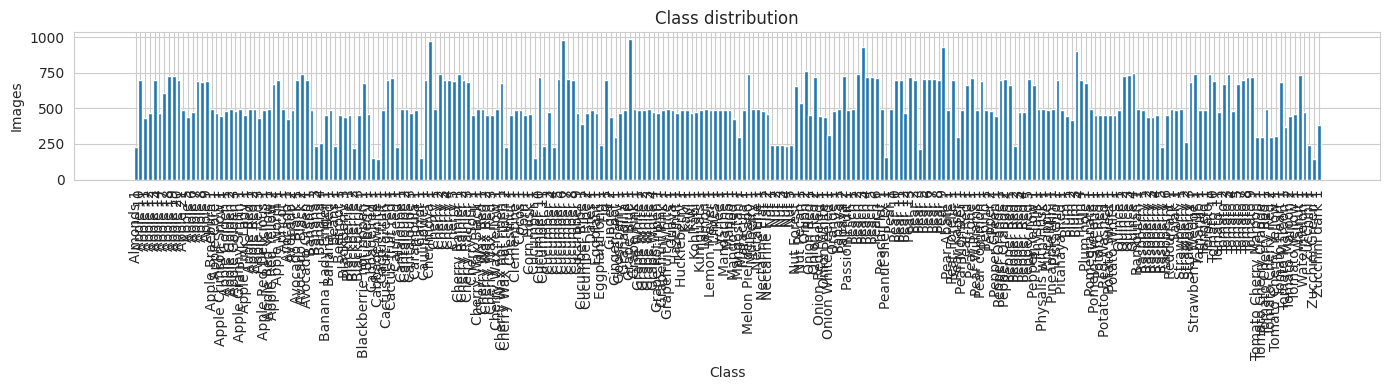

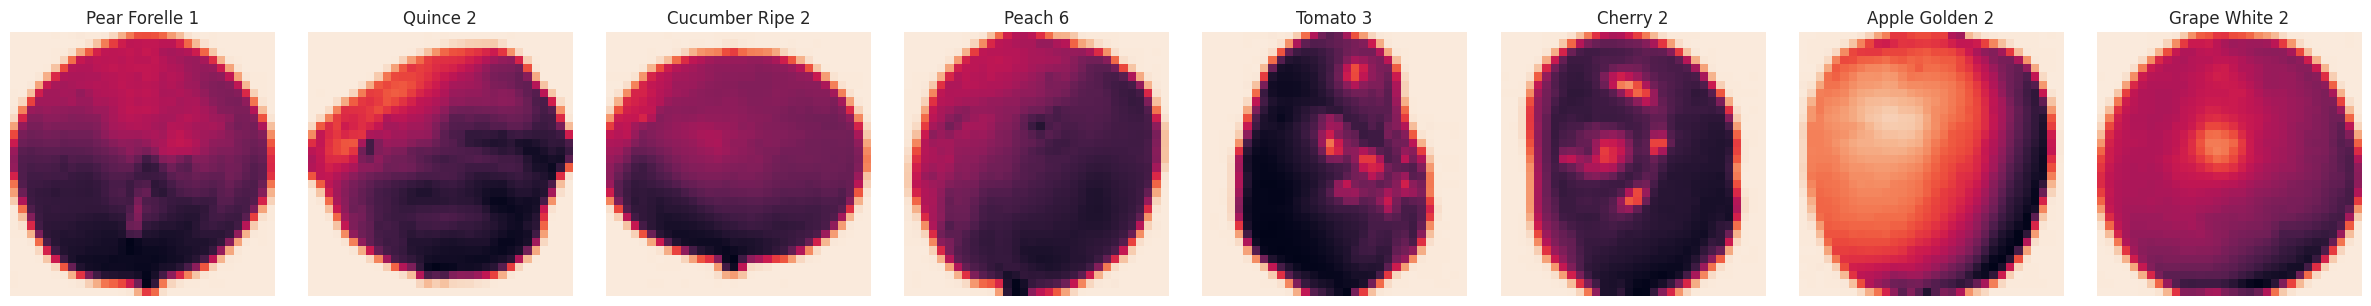

In [9]:
label_counts = {}
for _, lbl in full_train_dataset_fg.samples:
    label_counts[lbl] = label_counts.get(lbl, 0) + 1

labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]

plt.figure(figsize=(14, 4))
plt.bar(labels_sorted, counts_sorted)
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Random sample images
n_show = 8
indices = random.sample(range(len(train_dataset_fg)), n_show)
fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
for ax, idx in zip(axes, indices):
    img, label_idx = train_dataset_fg[idx]
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_train_dataset_fg.idx_to_label[int(label_idx)])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Grayscale histogram features

In [10]:
def gray_hist_features(X, bins=16, img_shape=(1, 64, 64)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.clip(img, 0.0, 1.0)
        ch_norm = img.astype(np.float32).ravel()
        hist, _ = np.histogram(ch_norm, bins=bin_edges, density=True)
        feats[i] = hist
    return feats

In [11]:
X_train_gray = gray_hist_features(X_train_np, bins=16, img_shape=(1, size, size))
X_val_gray   = gray_hist_features(X_val_np,   bins=16, img_shape=(1, size, size))
X_test_gray  = gray_hist_features(X_test_np,  bins=16, img_shape=(1, size, size))

print(X_train_gray.shape)
print(X_val_gray.shape)
print(X_test_gray.shape)

(91240, 16)
(39104, 16)
(43442, 16)


## Models on grayscale hist features (kNN, SVM, RF)

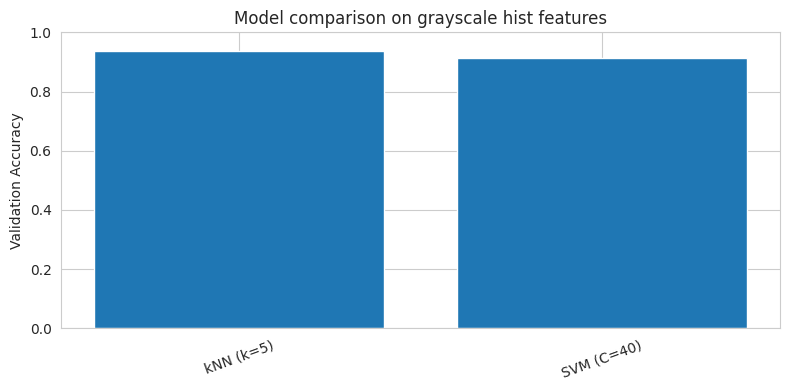

[('kNN (k=5)', 0.9385740589198036), ('SVM (C=40)', 0.9134871112929623)]

Peak RAM during fit:
kNN (k=5): RSS 2036.7 MB | Python 4.3 MB
SVM (C=40): RSS 2146.9 MB | Python 143.7 MB
Saved checkpoints: [PosixPath('artifacts/checkpoints/fruit360/gray_hist/knn/20260211-163818_b251d679'), PosixPath('artifacts/checkpoints/fruit360/gray_hist/svm/20260211-163820_14d30c2c')]


In [12]:
scaler_gray = StandardScaler()
X_train_gray_std = scaler_gray.fit_transform(X_train_gray)
X_val_gray_std = scaler_gray.transform(X_val_gray)

k_list = [5, 7, 9, 11]
C_list = [10, 20, 40]
rf_depth_list = [20, 30]

results = []
mem_results = []

# kNN
best_knn_acc = 0.0
best_k = None
best_knn_model = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_gray_std, y_train_np)
    y_val_pred = knn.predict(X_val_gray_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
        best_knn_model = knn
results.append((f"kNN (k={best_k})", best_knn_acc))

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C)
    svm.fit(X_train_gray_std, y_train_np)
    y_val_pred = svm.predict(X_val_gray_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
results.append((f"SVM (C={best_C})", best_svm_acc))

# Random Forest
# best_rf_acc = 0.0
# best_depth = None
# for depth in rf_depth_list:
#     rf = RandomForestClassifier(
#         n_estimators=300,
#         max_depth=depth,
#         max_features="sqrt",
#         random_state=RANDOM_STATE,
#         n_jobs=-1
#     )
#     rf.fit(X_train_gray_std, y_train_np)
#     y_val_pred = rf.predict(X_val_gray_std)
#     acc = accuracy_score(y_val_np, y_val_pred)
#     if acc > best_rf_acc:
#         best_rf_acc = acc
#         best_depth = depth
# results.append((f"RF (depth={best_depth})", best_rf_acc))

# Measure peak RAM on best models
best_knn = KNeighborsClassifier(n_neighbors=best_k)
fit_with_peak(best_knn, X_train_gray_std, y_train_np, f"kNN (k={best_k})", mem_results)

best_svm = SVC(kernel="rbf", C=best_C)
fit_with_peak(best_svm, X_train_gray_std, y_train_np, f"SVM (C={best_C})", mem_results)

# best_rf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=best_depth,
#     max_features="sqrt",
#     random_state=RANDOM_STATE,
#     n_jobs=-1
# )
# fit_with_peak(best_rf, X_train_gray_std, y_train_np, f"RF (depth={best_depth})", mem_results)

# Plot results
labels, accs = zip(*results)
plt.figure(figsize=(8, 4))
plt.bar(labels, accs)
plt.ylabel("Validation Accuracy")
plt.title("Model comparison on grayscale hist features")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print(results)
print_memory_results(mem_results)

# Save checkpoints (best kNN + best SVM only)
color_bins = 16
meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": "gray_hist",
    "img_size": size,
    "bins": color_bins,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
}

ckpt_paths = []
if best_knn_model is not None:
    ckpt_paths.append(
        save_checkpoint(
            best_knn_model,
            scaler_gray,
            {
                **meta_base,
                "model": "knn",
                "params": {"n_neighbors": best_k},
            },
            save_meta=False,
        )
    )
if best_svm_model is not None:
    ckpt_paths.append(
        save_checkpoint(
            best_svm_model,
            scaler_gray,
            {
                **meta_base,
                "model": "svm",
                "params": {"kernel": "rbf", "C": best_C},
            },
            save_meta=False,
        )
    )
print("Saved checkpoints:", ckpt_paths)